In [1]:
import torch
from phase_space_reconstruction.modeling import NormalizedQuadScan

rms_data = torch.load("rms_data.pt")

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_k = rms_data[0]
train_s11 = rms_data[1]
train_s22 = rms_data[2]
quad_length = torch.tensor(0.12)
drift = torch.tensor(3.38 - 0.12/2)
A = rms_data[1].max().sqrt()


In [3]:
# do bayesian linear regression using pyro
import pyro
from pyro import poutine

from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoNormal

class PyroNormalizedQuadScan(NormalizedQuadScan, PyroModule):
    def __init__(self, A, drift, quad_length):
        super().__init__(A, drift, quad_length)
        self.sigma = PyroSample(dist.Uniform(0., 1.0))
        
    def forward(self, k, y=None):
        sigma = self.sigma
        mean = super().forward(k)*1e6
        
        # NOTE: Laplace likelihood cooresponds to mean absolute error
        with pyro.plate("data", k.shape[0]):
            obs = pyro.sample("obs", dist.Laplace(mean, sigma), obs=y)
        return mean



model = PyroNormalizedQuadScan(A, drift, quad_length)
model.lambda_1 = PyroSample(dist.Normal(1.0,100.0))
model.lambda_2 = PyroSample(dist.Normal(1.0,100.0))
model.c = PyroSample(dist.Normal(0.0,100.0))

posterior_module = pyro.nn.PyroModule("model")
posterior_module.guide = AutoNormal(poutine.block(model, hide=['bm']))


print(dict(model.named_parameters()))

{}


[iter 0]  loss: 67.0777
[iter 500]  loss: 60.0906
[iter 1000]  loss: 8.4745
[iter 1500]  loss: 23.8573
[iter 2000]  loss: 6.6393
[iter 2500]  loss: 7.6032
[iter 3000]  loss: 4.8606
[iter 3500]  loss: 4.8904


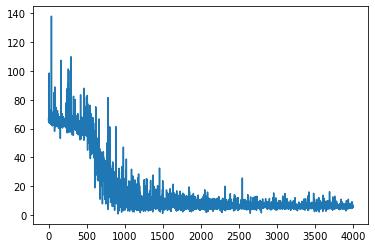

In [4]:
from pyro.infer import SVI, Trace_ELBO
import matplotlib.pyplot as plt

def train(model, guide, *args, lr=0.001, n_steps=201, verbose=False):
    pyro.clear_param_store()
    initial_lr = lr
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})
    svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

    losses = []
    for step in range(n_steps):
        loss = svi.step(*args)
        losses.append(loss)
        if step % 500 == 0 and verbose:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

    return losses

losses= train(
    model,posterior_module.guide, train_k, train_s11*1e6,
    lr=0.01,n_steps=4000, verbose=True
)
plt.plot(losses)


tensor([3.1135e-06, 3.4849e-06, 4.1150e-06, 4.8733e-06, 5.4393e-06])
tensor(4.1775e-06)
tensor(7.1035e-07)


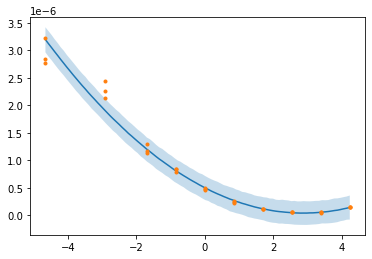

In [5]:
posterior_predictive = Predictive(model, num_samples=10000, parallel=True,
                               guide=posterior_module.guide)
test_k = torch.linspace(train_k.min(),train_k.max(),100)

posterior_samples = posterior_predictive(test_k)

def get_stats(samples):
    mean = torch.mean(samples, dim=0)
    l = torch.quantile(samples, 0.05, dim=0)
    u = torch.quantile(samples, 0.95, dim=0)
    return mean, l, u

fig, ax = plt.subplots()
m, l, u = get_stats(posterior_samples["obs"].squeeze()/1e6)
ax.plot(test_k.squeeze().cpu(), m.cpu())
ax.fill_between(test_k.squeeze().cpu(), l.cpu(), u.cpu(), alpha=0.25)

ax.plot(train_k.squeeze().cpu(), train_s11.squeeze().cpu(), '.')

c = posterior_samples["c"]
l1 = posterior_samples["lambda_1"]
l2 = posterior_samples["lambda_2"]

norm_c = torch.tanh(c)
norm_emit = (l1**2 * l2**2 * (1 - norm_c**2)).sqrt()
emit = norm_emit * A ** 2
emit=emit* 63.0 / 0.511

qs = torch.quantile(emit, torch.tensor([0.05,0.5-0.34,0.5,0.5+0.34,0.95]))
print(qs)
print(emit.mean())
print(emit.std())